## CHALLENGE DI KELAS

- Aura Najma Kustiananda (164221053)

### Import Data dan Library

In [41]:
import numpy as np
import pandas as pd

import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.classify.util import accuracy
from nltk.tokenize import word_tokenize
import string
import re

from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = r'C:\Users\Acer\OneDrive\Pictures\Kuliah\Semester 5\Data Mining II - Laprak\data datmin ii\Spam_text_message.csv'

df = pd.read_csv(file_path)

df.head()


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


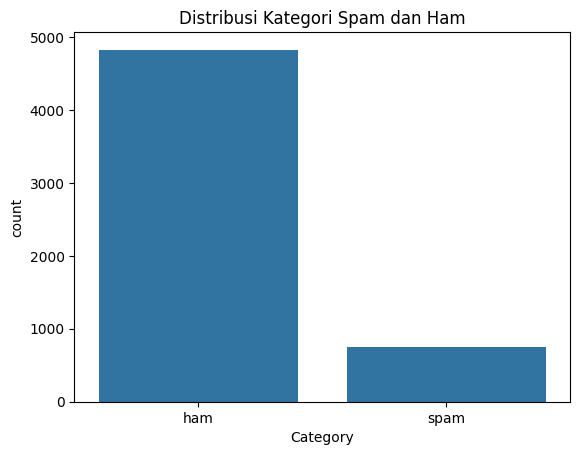

In [4]:
sns.countplot(data=df, x='Category')
plt.title('Distribusi Kategori Spam dan Ham')
plt.show()

count    5572.000000
mean       80.368988
std        59.926946
min         2.000000
25%        35.750000
50%        61.000000
75%       122.000000
max       910.000000
Name: Message Length, dtype: float64


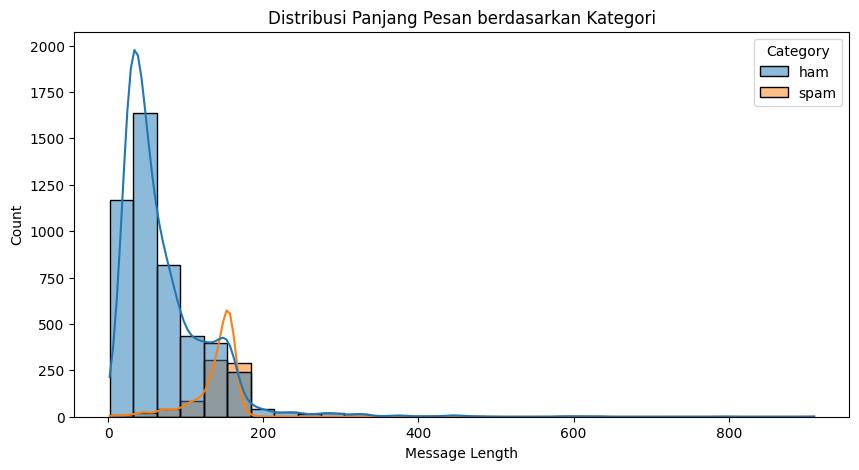

In [5]:
df['Message Length'] = df['Message'].apply(len)

# Statistik deskriptif panjang pesan
print(df['Message Length'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Message Length', hue='Category', bins=30, kde=True)
plt.title('Distribusi Panjang Pesan berdasarkan Kategori')
plt.show()

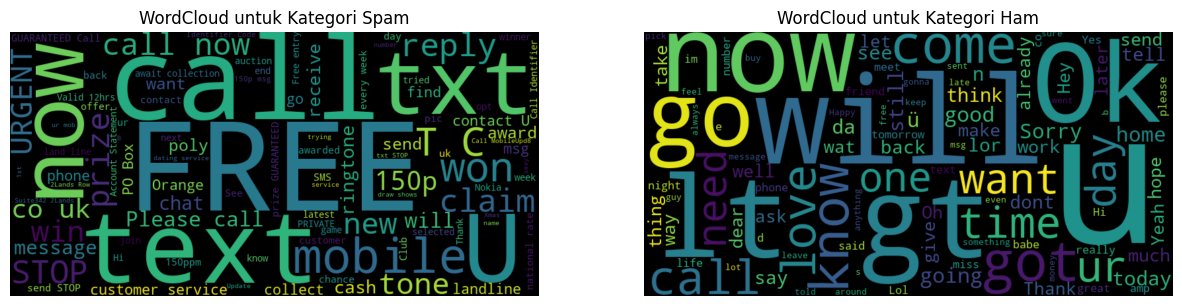

In [7]:
spam_messages = ' '.join(df[df['Category'] == 'spam']['Message'])
ham_messages = ' '.join(df[df['Category'] == 'ham']['Message'])

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
wordcloud_spam = WordCloud(width=800, height=400, max_words=100).generate(spam_messages)
wordcloud_ham = WordCloud(width=800, height=400, max_words=100).generate(ham_messages)

ax[0].imshow(wordcloud_spam, interpolation='bilinear')
ax[0].set_title('WordCloud untuk Kategori Spam')
ax[0].axis('off')

ax[1].imshow(wordcloud_ham, interpolation='bilinear')
ax[1].set_title('WordCloud untuk Kategori Ham')
ax[1].axis('off')

plt.show()

Data berasal dari Kaggle dan merupakan data klasifikasi apakah suatu SMS termasuk spam atau ham.

### Pre-processing

In [13]:
list_bersih = []
for i in range(len(df)):
    teks = df['Message'][i]
    teks_bersih = re.sub(r'[^\w\s]', '', teks.lower())
    list_bersih.append(teks_bersih)
    print("Teks ke", i, "sudah dibersihkan")



Teks ke 0 sudah dibersihkan
Teks ke 1 sudah dibersihkan
Teks ke 2 sudah dibersihkan
Teks ke 3 sudah dibersihkan
Teks ke 4 sudah dibersihkan
Teks ke 5 sudah dibersihkan
Teks ke 6 sudah dibersihkan
Teks ke 7 sudah dibersihkan
Teks ke 8 sudah dibersihkan
Teks ke 9 sudah dibersihkan
Teks ke 10 sudah dibersihkan
Teks ke 11 sudah dibersihkan
Teks ke 12 sudah dibersihkan
Teks ke 13 sudah dibersihkan
Teks ke 14 sudah dibersihkan
Teks ke 15 sudah dibersihkan
Teks ke 16 sudah dibersihkan
Teks ke 17 sudah dibersihkan
Teks ke 18 sudah dibersihkan
Teks ke 19 sudah dibersihkan
Teks ke 20 sudah dibersihkan
Teks ke 21 sudah dibersihkan
Teks ke 22 sudah dibersihkan
Teks ke 23 sudah dibersihkan
Teks ke 24 sudah dibersihkan
Teks ke 25 sudah dibersihkan
Teks ke 26 sudah dibersihkan
Teks ke 27 sudah dibersihkan
Teks ke 28 sudah dibersihkan
Teks ke 29 sudah dibersihkan
Teks ke 30 sudah dibersihkan
Teks ke 31 sudah dibersihkan
Teks ke 32 sudah dibersihkan
Teks ke 33 sudah dibersihkan
Teks ke 34 sudah dibersi

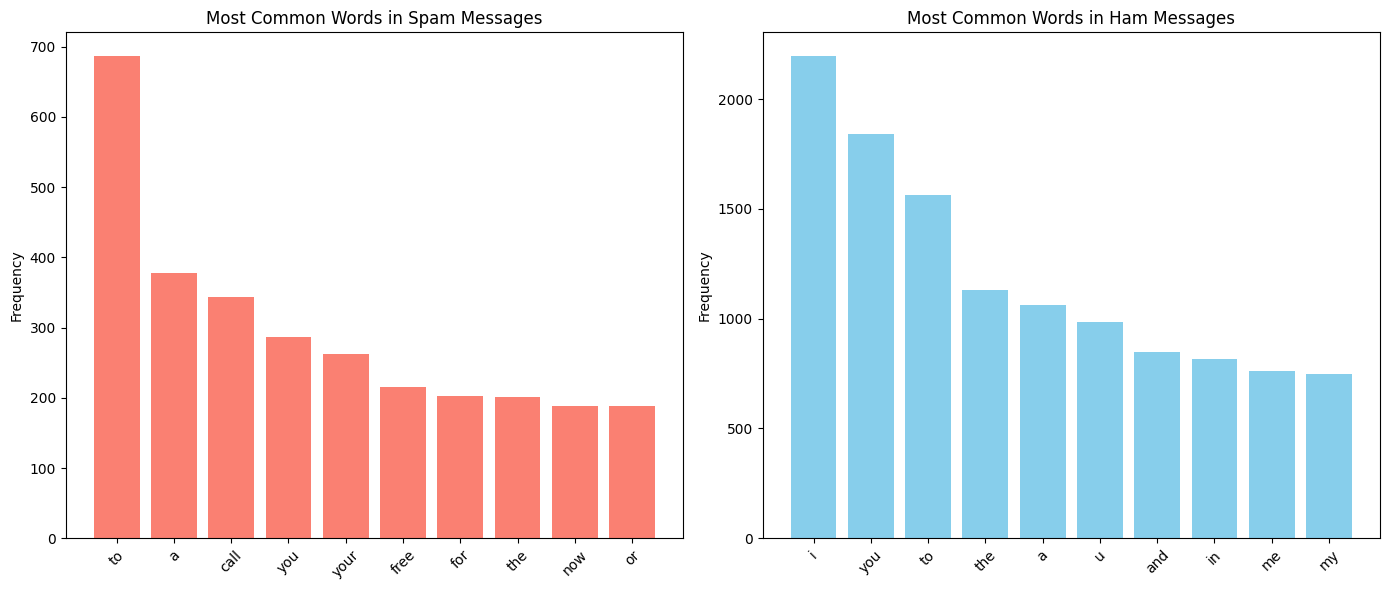

In [14]:

spam_texts, ham_texts = [], []

for i in range(len(df)):
    teks = df['Message'][i]
    teks_bersih = re.sub(r'[^\w\s]', '', teks.lower())
    if df['Category'][i] == 'spam':
        spam_texts.append(teks_bersih)
    elif df['Category'][i] == 'ham':
        ham_texts.append(teks_bersih)

spam_words = ' '.join(spam_texts).split()
ham_words = ' '.join(ham_texts).split()

common_spam_words = Counter(spam_words).most_common(10)
common_ham_words = Counter(ham_words).most_common(10)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
spam_words, spam_counts = zip(*common_spam_words)
plt.bar(spam_words, spam_counts, color='salmon')
plt.title('Most Common Words in Spam Messages')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
ham_words, ham_counts = zip(*common_ham_words)
plt.bar(ham_words, ham_counts, color='skyblue')
plt.title('Most Common Words in Ham Messages')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [15]:
stop_word_set = set(stopwords.words('english'))


def remove_stopwords(text, stopwords):
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

list_bersih_stop = []

for i, teks in enumerate(list_bersih):
    teks_bersih_stop = remove_stopwords(teks, stop_word_set)
    list_bersih_stop.append(teks_bersih_stop)
    print(f"Teks ke {i} sudah dibersihkan")

Teks ke 0 sudah dibersihkan
Teks ke 1 sudah dibersihkan
Teks ke 2 sudah dibersihkan
Teks ke 3 sudah dibersihkan
Teks ke 4 sudah dibersihkan
Teks ke 5 sudah dibersihkan
Teks ke 6 sudah dibersihkan
Teks ke 7 sudah dibersihkan
Teks ke 8 sudah dibersihkan
Teks ke 9 sudah dibersihkan
Teks ke 10 sudah dibersihkan
Teks ke 11 sudah dibersihkan
Teks ke 12 sudah dibersihkan
Teks ke 13 sudah dibersihkan
Teks ke 14 sudah dibersihkan
Teks ke 15 sudah dibersihkan
Teks ke 16 sudah dibersihkan
Teks ke 17 sudah dibersihkan
Teks ke 18 sudah dibersihkan
Teks ke 19 sudah dibersihkan
Teks ke 20 sudah dibersihkan
Teks ke 21 sudah dibersihkan
Teks ke 22 sudah dibersihkan
Teks ke 23 sudah dibersihkan
Teks ke 24 sudah dibersihkan
Teks ke 25 sudah dibersihkan
Teks ke 26 sudah dibersihkan
Teks ke 27 sudah dibersihkan
Teks ke 28 sudah dibersihkan
Teks ke 29 sudah dibersihkan
Teks ke 30 sudah dibersihkan
Teks ke 31 sudah dibersihkan
Teks ke 32 sudah dibersihkan
Teks ke 33 sudah dibersihkan
Teks ke 34 sudah dibersi

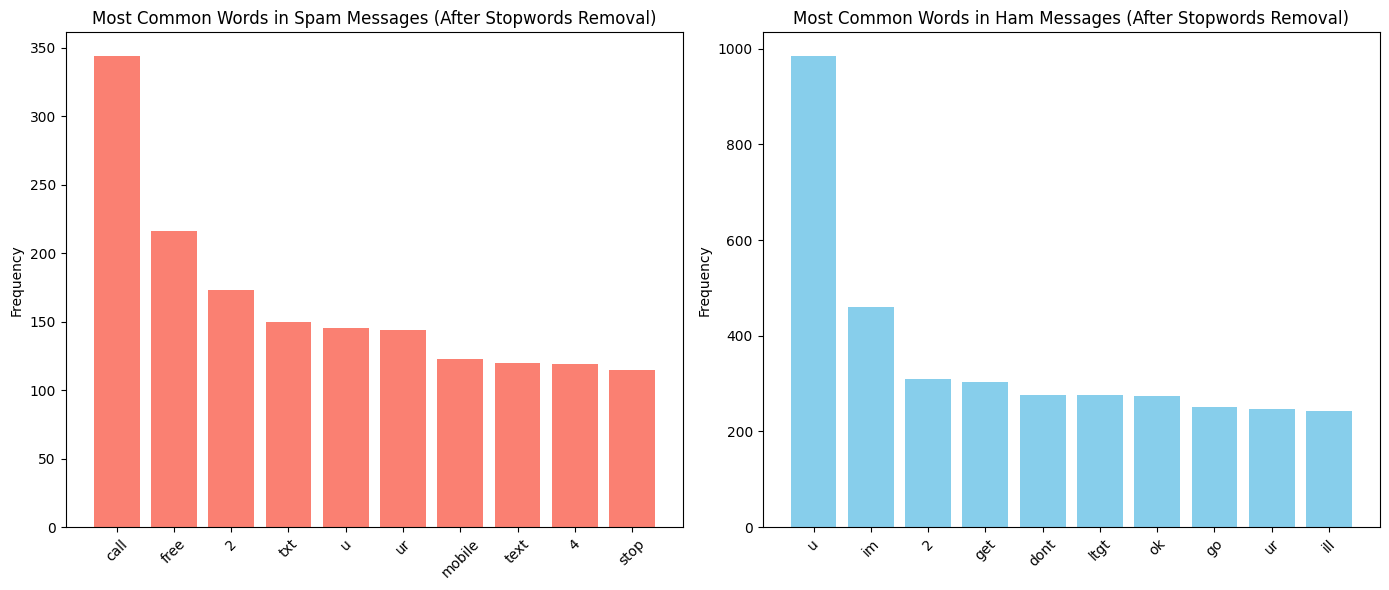

In [16]:
spam_texts_stop = [list_bersih_stop[i] for i in range(len(df)) if df['Category'][i] == 'spam']
ham_texts_stop = [list_bersih_stop[i] for i in range(len(df)) if df['Category'][i] == 'ham']

spam_words_stop = ' '.join(spam_texts_stop).split()
ham_words_stop = ' '.join(ham_texts_stop).split()

common_spam_words_stop = Counter(spam_words_stop).most_common(10)
common_ham_words_stop = Counter(ham_words_stop).most_common(10)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
spam_words, spam_counts = zip(*common_spam_words_stop)
plt.bar(spam_words, spam_counts, color='salmon')
plt.title('Most Common Words in Spam Messages (After Stopwords Removal)')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
ham_words, ham_counts = zip(*common_ham_words_stop)
plt.bar(ham_words, ham_counts, color='skyblue')
plt.title('Most Common Words in Ham Messages (After Stopwords Removal)')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

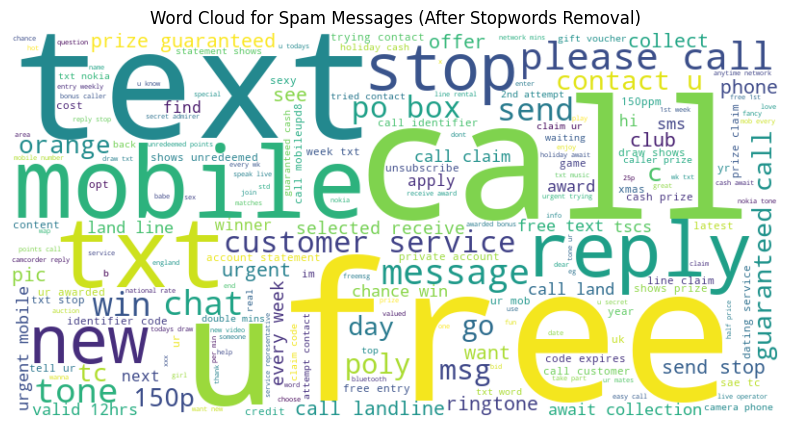

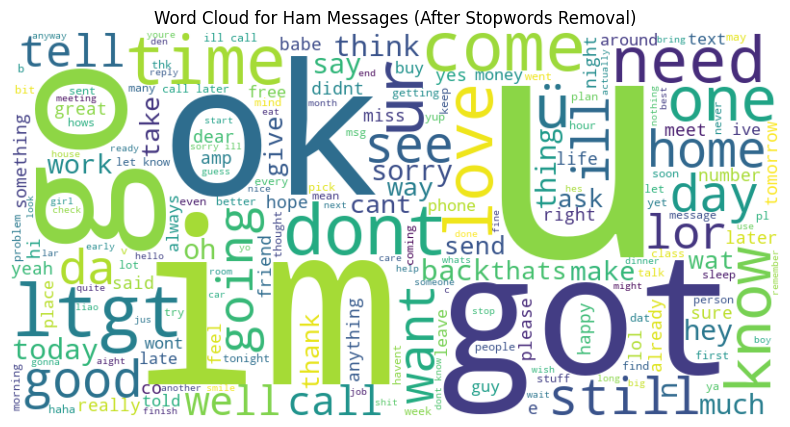

In [17]:
spam_wordcloud_stop = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_words_stop))
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud_stop, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages (After Stopwords Removal)')
plt.show()

ham_wordcloud_stop = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ham_words_stop))
plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud_stop, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages (After Stopwords Removal)')
plt.show()

Teks telah dipreprocessing dengan dibersihkan dari tanda baca, di-lowercase secara serentak, dan dihapus stopwordsnya.

### EKSTRAKSI FITUR DAN SPLITTING DATA

In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Message'])  
print(X.shape)
y = df['Category'].map({'ham': 0, 'spam': 1})  


(5572, 8709)


Fitur diekstraksi menggunakan TF-IDF untuk variabel X, dan variabel Y-nya dimapping agar menjadi dummy

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


Data dipisah sebanyak 64 persen untuk train, 16 persen untuk val, dan 20 persen untuk test

In [20]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

Terdapat ketimpangan kelas pada data, di mana pesan yang memiliki label spam sebanyak 13.4 persen dari keseluruhan data, sementara sisanya diberi label ham.

### RANDOM FOREST

In [21]:
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', random_state=42)

Model klasifikasi Random Forest diatur dengan class_weight = balanced karena adanya ketimpangan kelas. Dengan class_weight yang diatur, harapannya model bisa lebih adil ke kelas ham dan spam.

In [22]:
y_val_pred = rf_classifier.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['ham', 'spam']))

Validation Accuracy: 97.20%
Validation Set Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       772
        spam       1.00      0.79      0.88       120

    accuracy                           0.97       892
   macro avg       0.98      0.90      0.93       892
weighted avg       0.97      0.97      0.97       892



Dari data validation, akurasi yang didapatkan sebesar 97.2 persen, yang merupakan akurasi yang baik. Semua pesan yang diprediksi sebagai spam adalah spam, tetapi hanya 79 persen pesan yang benar-benar spam dilabeli sebagai spam, sementara sisanya diklasifikasikan sebagai ham. Ini menyebabkan precision ham menjadi sebesar 97 persen, karena 3 persennya kemungkinan besar adalah pesan berlabel spam yang salah diklasifikasikan. Tetapi, karena nilai recall-nya sebesar 1, artinya semua pesan ham berhasil diprediksi sebagai ham juga.

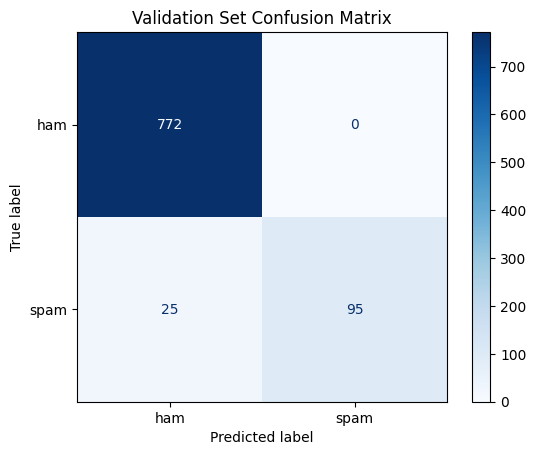

In [23]:
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_val, display_labels=['ham', 'spam']).plot(cmap='Blues') 
plt.title('Validation Set Confusion Matrix')
plt.show()

Terdapat 25 pesan spam yang salah diprediksi sebagai ham.

In [24]:
val_misclassified = df.iloc[y_val.index][y_val != y_val_pred]
val_misclassified['Predicted'] = y_val_pred[y_val != y_val_pred]
val_misclassified['Actual'] = y_val[y_val != y_val_pred]

print("Misclassified Instances in Validation Set:")
for idx, row in val_misclassified.iterrows():
    print(f"Index: {idx}, Message: {row['Message']}")
    print(f"Actual: {row['Actual']}, Predicted: {row['Predicted']}\n")


Misclassified Instances in Validation Set:
Index: 943, Message: How about getting in touch with folks waiting for company? Just txt back your NAME and AGE to opt in! Enjoy the community (150p/SMS)
Actual: 1, Predicted: 0

Index: 5381, Message: You have 1 new message. Call 0207-083-6089
Actual: 1, Predicted: 0

Index: 5427, Message: Santa Calling! Would your little ones like a call from Santa Xmas eve? Call 09058094583 to book your time.
Actual: 1, Predicted: 0

Index: 5098, Message: TheMob>Hit the link to get a premium Pink Panther game, the new no. 1 from Sugababes, a crazy Zebra animation or a badass Hoody wallpaper-all 4 FREE!
Actual: 1, Predicted: 0

Index: 955, Message: Filthy stories and GIRLS waiting for your
Actual: 1, Predicted: 0

Index: 264, Message: Hey I am really horny want to chat or see me naked text hot to 69698 text charged at 150pm to unsubscribe text stop 69698
Actual: 1, Predicted: 0

Index: 305, Message: SMS. ac Blind Date 4U!: Rodds1 is 21/m from Aberdeen, United

In [25]:
y_test_pred = rf_classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['ham', 'spam']))

Test Accuracy: 98.03%
Test Set Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



Akurasi dari data test sebesar 98.03 persen menunjukkan bahwa model Random Forest merupakan model yang baik. Karena akurasinya tidak jauh berbeda dengan data validasi, ini juga menunjukkan model tidak overfitting atau underfitting. Terdapat peningkatan akurasi pada recall spam. Dari seluruh pesan berlabel spam, hanya 15 persen yang salah diklasifikasikan, mengakibatkan nilai precision ham sebesar 0.98. Kesimpulannya, model Random Forest ini adalah model yang baik untuk mengklasifikasikan pesan berlabel ham, tetapi membutuhkan peningkatan untuk pesan berlabel spam.

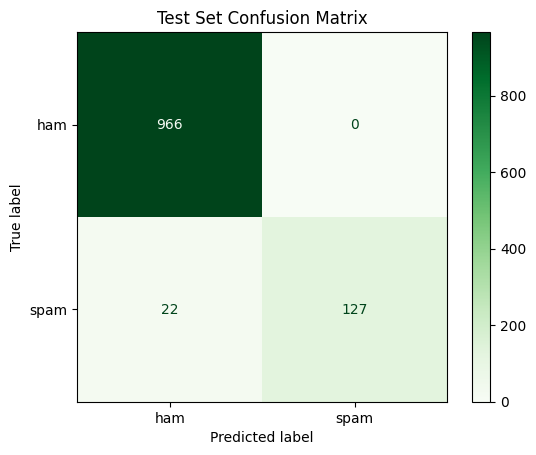

In [26]:
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=['ham', 'spam']).plot(cmap='Greens')  
plt.title('Test Set Confusion Matrix')
plt.show()

Terdapat 22 pesan spam yang salah diklasifikasikan sebagai ham.

In [27]:
test_misclassified = df.iloc[y_test.index][y_test != y_test_pred]
test_misclassified['Predicted'] = y_test_pred[y_test != y_test_pred]
test_misclassified['Actual'] = y_test[y_test != y_test_pred]

print("\nMisclassified Instances in Test Set:")
for idx, row in test_misclassified.iterrows():
    print(f"Index: {idx}, Message: {row['Message']}")
    print(f"Actual: {row['Actual']}, Predicted: {row['Predicted']}\n")


Misclassified Instances in Test Set:
Index: 881, Message: Reminder: You have not downloaded the content you have already paid for. Goto http://doit. mymoby. tv/ to collect your content.
Actual: 1, Predicted: 0

Index: 3864, Message: Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
Actual: 1, Predicted: 0

Index: 2575, Message: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
Actual: 1, Predicted: 0

Index: 3548, Message: Rock yr chik. Get 100's of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel
Actual: 1, Predicted: 0

Index: 2402, Message: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
Actual: 1, Predicted: 0

Index: 4527, Message: I want some

Kesalahan klasifikasi pada model Random Forest ini dapat disebabkan oleh beberapa hal, seperti pola pesan spam yang mirip dengan ham sehingga model salah memprediksi/ Contohnya adalah "Hello darling how are you today? I would love to have a chat..." dan "Do you realize that in about 40 years, we'll have...". Alasan lain yang mungkin adalah model kurang belajar dari data berlabel spam karena adanya ketimpangan data. Contohnya, pesan seperti "Reminder: You have not downloaded the content.." atau "Xmas & New Years Eve tickets are now on sale..."  dapat dianggap sebagai pesan sungguhan yang mengingatkan dan mempromosikan sesuatu. Selain itu, banyak pesan spam yang menggunakan kata-kata biasa seperti pesan berlabel ham, seperti hi, call, atau free, sehingga model pun sulit menangkap pola pesan berlabel spam.

### NAIVE BAYES

In [28]:
nb_classifier = MultinomialNB(class_prior=[0.5, 0.5]) 
nb_classifier.fit(X_train, y_train)



MultinomialNB(class_prior=[0.5, 0.5])

In [29]:
y_val_pred = nb_classifier.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['ham', 'spam']))

Validation Accuracy: 0.97
Validation Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       772
        spam       0.88      0.89      0.88       120

    accuracy                           0.97       892
   macro avg       0.93      0.94      0.93       892
weighted avg       0.97      0.97      0.97       892



<Figure size 800x600 with 0 Axes>

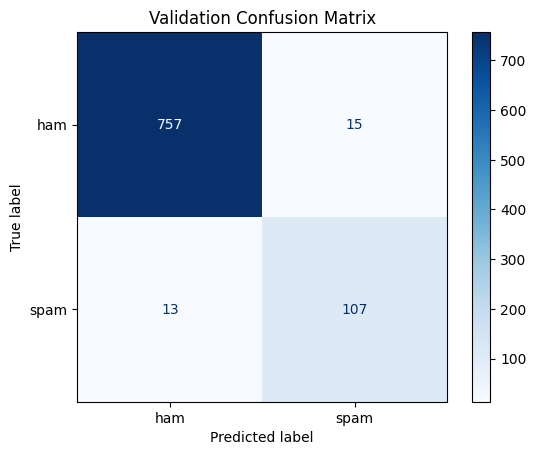

In [30]:
val_cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=['ham', 'spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

In [31]:
val_misclassified = df.iloc[y_val.index][y_val != y_val_pred]
val_misclassified['Predicted'] = y_val_pred[y_val != y_val_pred]
val_misclassified['Actual'] = y_val[y_val != y_val_pred]

print("Misclassified Instances in Validation Set:")
for idx, row in val_misclassified.iterrows():
    print(f"Index: {idx}, Message: {row['Message']}")
    print(f"Actual: {row['Actual']}, Predicted: {row['Predicted']}\n")

Misclassified Instances in Validation Set:
Index: 3358, Message: Brainless Baby Doll..:-D;-), vehicle sariyag drive madoke barolla..
Actual: 0, Predicted: 1

Index: 4021, Message: University of southern california.
Actual: 0, Predicted: 1

Index: 943, Message: How about getting in touch with folks waiting for company? Just txt back your NAME and AGE to opt in! Enjoy the community (150p/SMS)
Actual: 1, Predicted: 0

Index: 3788, Message: WHORE YOU ARE UNBELIEVABLE.
Actual: 0, Predicted: 1

Index: 1381, Message: i dnt wnt to tlk wid u
Actual: 0, Predicted: 1

Index: 1137, Message: Dont forget you can place as many FREE Requests with 1stchoice.co.uk as you wish. For more Information call 08707808226.
Actual: 1, Predicted: 0

Index: 1893, Message: CALL 09090900040 & LISTEN TO EXTREME DIRTY LIVE CHAT GOING ON IN THE OFFICE RIGHT NOW TOTAL PRIVACY NO ONE KNOWS YOUR [sic] LISTENING 60P MIN 24/7MP 0870753331018+
Actual: 1, Predicted: 0

Index: 5427, Message: Santa Calling! Would your little on

In [32]:
y_test_pred = nb_classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['ham', 'spam']))


Test Accuracy: 0.97
Test Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       966
        spam       0.86      0.91      0.88       149

    accuracy                           0.97      1115
   macro avg       0.92      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115



<Figure size 800x600 with 0 Axes>

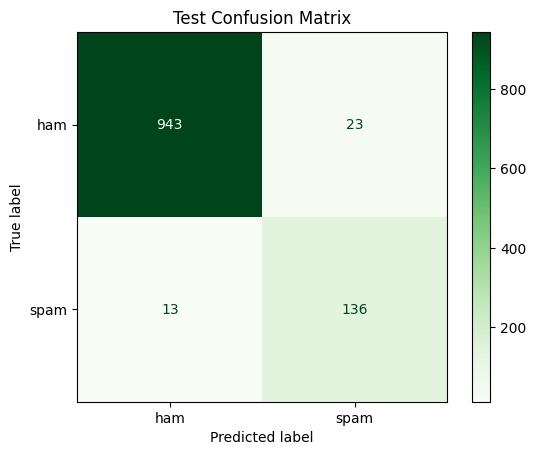

In [33]:
test_cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['ham', 'spam'])
disp_test.plot(cmap=plt.cm.Greens)  
plt.title("Test Confusion Matrix")
plt.show()

In [34]:
test_misclassified = df.iloc[y_test.index][y_test != y_test_pred]
test_misclassified['Predicted'] = y_test_pred[y_test != y_test_pred]
test_misclassified['Actual'] = y_test[y_test != y_test_pred]

print("\nMisclassified Instances in Test Set:")
for idx, row in test_misclassified.iterrows():
    print(f"Index: {idx}, Message: {row['Message']}")
    print(f"Actual: {row['Actual']}, Predicted: {row['Predicted']}\n")


Misclassified Instances in Test Set:
Index: 4937, Message: K..k.:)congratulation ..
Actual: 0, Predicted: 1

Index: 1961, Message: Guess what! Somebody you know secretly fancies you! Wanna find out who it is? Give us a call on 09065394973 from Landline DATEBox1282EssexCM61XN 150p/min 18
Actual: 1, Predicted: 0

Index: 3864, Message: Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
Actual: 1, Predicted: 0

Index: 2575, Message: Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
Actual: 1, Predicted: 0

Index: 2245, Message: No management puzzeles.
Actual: 0, Predicted: 1

Index: 5022, Message: :-( sad puppy noise
Actual: 0, Predicted: 1

Index: 2402, Message: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
Actual: 1, Predict

Kesalahan klasifikasi pada model Naive Bayes mungkin lebih beragam dari model Random Forest karena model ini salah memprediksi baik pesan berlabel spam atau ham.

**Alasan Kesalahan Klasifikasi untuk Spam**

1. Karena model Naive Bayes bekerja dengan asumsi independensi kata-kata, sehingga ketika ada kata-kata yang muncul pada pesan spam tapi sering muncul pada pesan ham, terjadi kesalahan klasifikasi.

2. Struktur kalimat yang terlalu umum dan konteks yang ambigu, sehingga ketika pesan spam menggunakan kalimat seperti percakapan sehari-hari, model bisa salah mengklasifikasikan. Contohnya adalah "Hi this is Amy, we will be sending you a free phone number in a couple of days, which will give you an access to all the adult parties..." di mana bagian adult parties menunjukkan bahwa pesan ini spam, tetapi karena awalnya ini terlihat seperti pesan dari seorang teman, model salah mengklasifikasikan.

**Alasan Kesalahan Klasifikasi untuk Ham**

1. Kata-kata yang muncul pada pesan ham sering muncul di pesan spam, contohnya pada pesan "Brainless Baby Doll..:-D;-), vehicle sariyag drive madoke barolla.."

2. Pesan yang ambigu, tidak jelas, terlalu umum dan kerap menggunakan singkatan. Contohnya pada pesan "i dnt wnt to tlk wid u", ini mungkin berarti pesan sungguhan dari seseorang yang merasa kesal pada penerima sehingga menggunakan bahasa yang disingkat-singkat, tetapi model malah mengklasifikasikannya menjadi spam.

## MODUL PRAKTIKUM

In [35]:
text1 = "In Brazil they drive on the right-hand side of the road. has a large coastline on the eastern side of South America"

token1 = word_tokenize(text1)
token1

['In',
 'Brazil',
 'they',
 'drive',
 'on',
 'the',
 'right-hand',
 'side',
 'of',
 'the',
 'road',
 '.',
 'has',
 'a',
 'large',
 'coastline',
 'on',
 'the',
 'eastern',
 'side',
 'of',
 'South',
 'America']

In [36]:
from nltk.probability import FreqDist
fdist1 = FreqDist(token1)
fdist1


FreqDist({'the': 3, 'on': 2, 'side': 2, 'of': 2, 'In': 1, 'Brazil': 1, 'they': 1, 'drive': 1, 'right-hand': 1, 'road': 1, ...})

In [37]:
fdist2 = fdist1.most_common(10)
fdist2

[('the', 3),
 ('on', 2),
 ('side', 2),
 ('of', 2),
 ('In', 1),
 ('Brazil', 1),
 ('they', 1),
 ('drive', 1),
 ('right-hand', 1),
 ('road', 1)]

In [38]:
kalimat = "Perekonomian Indonesia tidak sedang dalam pertumbuhan yang membanggakan."

daftar_stopwords = set(stopwords.words('indonesian'))

tokens = word_tokenize(kalimat)

tokens_without_stopword = [word for word in tokens if word.lower() not in daftar_stopwords]

print(tokens_without_stopword)

['Perekonomian', 'Indonesia', 'pertumbuhan', 'membanggakan', '.']


In [39]:

factory = StemmerFactory()
stemmer = factory.create_stemmer()


output = [(token + " : " + stemmer.stem(token)) for token in tokens_without_stopword]
output


['Perekonomian : ekonomi',
 'Indonesia : indonesia',
 'pertumbuhan : tumbuh',
 'membanggakan : bangga',
 '. : ']

In [40]:
a = set(stopwords.words("english"))

text2 = "Christiano Ronaldo was born on February 5, 1985, in Funchal, Madeira, Portugal."

text2_lower = word_tokenize(text2.lower())

filtered_words = [word for word in text2_lower if word not in a]

print(filtered_words)

['christiano', 'ronaldo', 'born', 'february', '5', ',', '1985', ',', 'funchal', ',', 'madeira', ',', 'portugal', '.']
